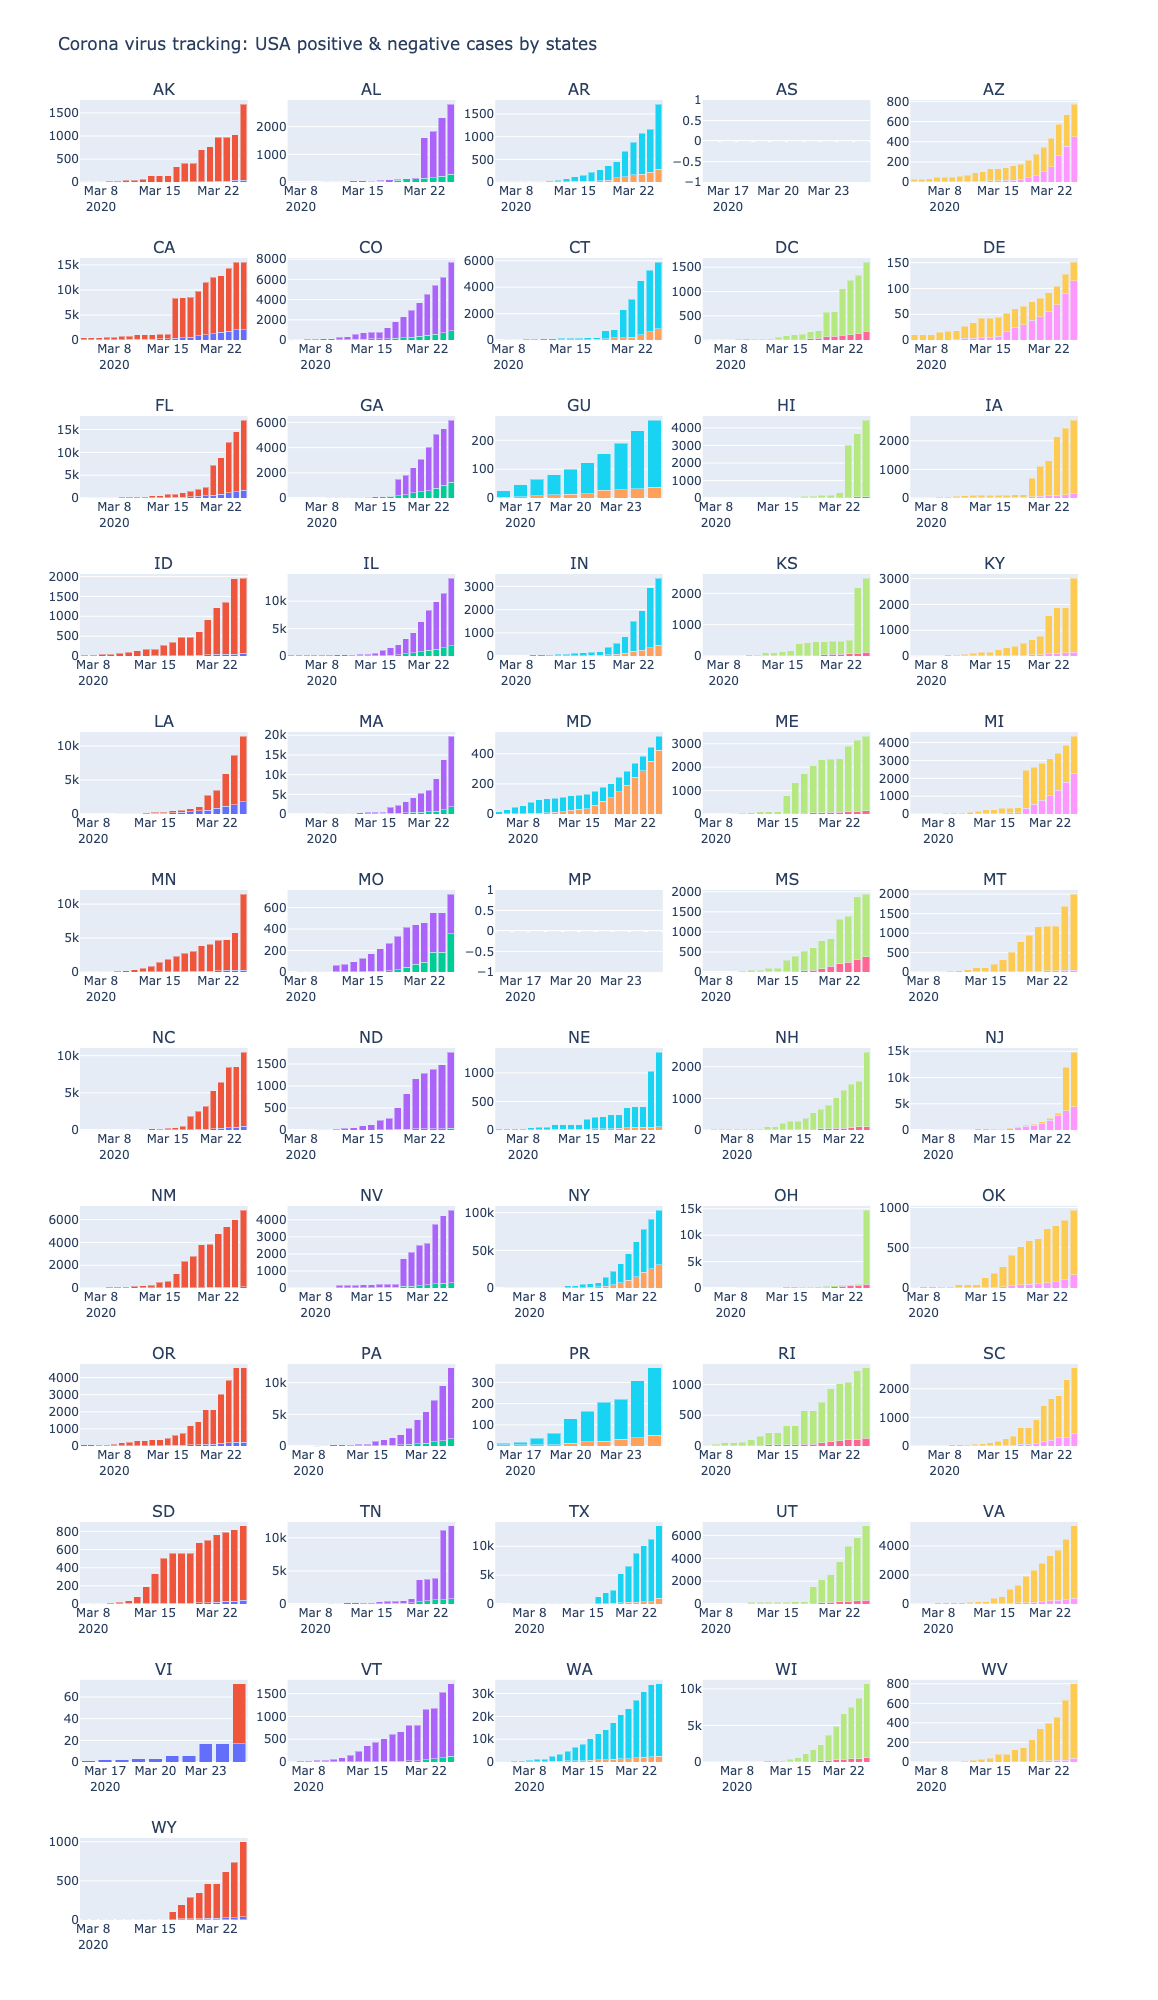

In [202]:
import importlib
import corona_plots
importlib.reload(corona_plots)

corona_plots.CoronaPlots.plot_global_cases(auto_open=True)
corona_plots.CoronaPlots.plot_usa_cases(auto_open=True)
corona_plots.CoronaPlots.plot_usa_pos_neg_tracking(auto_open=True)